In [1]:
%matplotlib inline
# %matplotlib widget # 跟圖互動，可以用點選圖片中的某位置觸發程式
%env KERAS_BACKEND=tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import shuffle
# from matplotlib.widgets import Cursor, Button
from ipywidgets import interact, IntSlider, Button
from ipywidgets import interact_manual
import IPython.display as ipd
import networkx as nx # draw graph vertex & edge
import pydub # audio
from numpy.fft import fft, ifft # , irfft, rfft # fourier transform
# import sympy as sym
# from sympy import S,N
# import locale # 資料處理 轉換數字格式

# from sklearn.linear_model import LinearRegression
# from keras.utils import np_utils #one hot encoding
# from keras.models import Sequential #神經網路的框架keras.models
from keras.layers import Dense, Activation, Embedding
# from keras.layers import LSTM
from keras.layers import Flatten # 將資料展平
# from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from keras.optimizers import SGD, Adadelta, Adam
from keras.models import model_from_json
# from keras.datasets import mnist # mnist內 包含手寫測試資料
# from keras.datasets import imdb # imdb內 包含電影評論資料
# from keras.preprocessing import sequence # 用來同整不同長度的電影評論，多的擷掉，少的補 0
# from keras.preprocessing.text import Tokenizer # 轉換文字成數字
# from sklearn.model_selection import train_test_split

#for Functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers import Reshape
# #for Functional API transfer learning
from keras.layers.core import Lambda
from keras import backend as K
from keras import metrics

# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

# import matplotlib.image as mpimg #import image file

###################################################################
#################### setting functions for io #####################
###################################################################
def playAudio(x, rate = 0):
    if type(x)!=np.ndarray:
        ipd.display(ipd.Audio(x))
    elif rate == 0:
        print("input rate!")
        return
    elif len(x.shape) > 1:
        ipd.display(ipd.Audio(x.T.astype(int), rate = rate))
    else:
        ipd.display(ipd.Audio(x.astype(int), rate = rate))

def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

###################################################################
############### setting functions for training data ###############
###################################################################
def normalize(data):
    data = data - min_value
    data = data / (max_value - min_value)
    return data
def inverse_normalize(data):
    data = data * (max_value - min_value)
    data = data + min_value
    return data

def fourier_transformation(aud_data):
    global chennel_length_fourier, segement_length_fourier
    chennel_length_fourier = 1 # = 2
    for idx in range(len(aud_data)):
        aud_data0 = np.zeros(2**(int(np.ceil(np.log2(len_data)))))
        aud_data0[0:len_data] = aud_data[idx,:,0]
        if chennel_length_fourier == 1:
            fourier0 = fft(aud_data0).real.astype(float)
            fourier0 = fourier0[0:len(fourier0)//2]
        else:
            fourier0 = fft(aud_data0).astype(float)
        if idx == 0:
            fourier = np.zeros((len(aud_data), len(fourier0), chennel_length_fourier))
        fourier[idx,:,0] = fourier0
        if chennel_length_fourier == 2:
            fourier[idx,:,1] = fourier0.imag

    global max_value_fourier, min_value_fourier
    max_value_fourier = np.max(fourier.reshape(-1))
    min_value_fourier = np.min(fourier.reshape(-1))
    segement_length_fourier = len(fourier[0])
    return fourier
def inverse_fourier_transformation(fourier):
    aud_data = np.zeros((len(fourier), len_data, 1))
    for idx in range(len(fourier)):
        if chennel_length_fourier == 1:
            fourier0 = np.zeros(len(fourier[idx,:,0]) * 2)
            fourier0[0:len(fourier[idx,:,0])] = fourier[idx,:,0]
            fourier0[len(fourier[idx,:,0]):] = fourier[idx,:,0][::-1]
            fourier0 = fourier0 + 1J * fourier0
        else:
            fourier0 = fourier[idx,:,0] + 1J * fourier[idx,:,1]
        aud_data0 = ifft(fourier0).real
        aud_data[idx,:,0] = aud_data0[0:len_data]
    return aud_data

def normalize_with_fourier(aud_data):
    fourier = fourier_transformation(aud_data)
    fourier = fourier - min_value_fourier
    fourier = fourier / (max_value_fourier - min_value_fourier)
    return fourier
def inverse_normalize_with_fourier(fourier):
    fourier = fourier * (max_value_fourier - min_value_fourier)
    fourier = fourier + min_value_fourier
    aud_data = inverse_fourier_transformation(fourier)
    return aud_data

def setting_training_data():
    global train0, chennel_length_audio, segement_length_sec, segement_length_audio
    global chennel_length, segement_length
    chennel_length_audio = 1
    segement_length_sec = 2
    segement_length_audio = segement_length_sec * rate
    train0 = song_array[0:segement_length_audio * (song_array.shape[0]//segement_length_audio), 0].copy()
    train0 = train0.reshape(-1, segement_length_audio, chennel_length_audio).astype(float)

    global max_value, min_value
    max_value = np.max(train0.reshape(-1))
    min_value = np.min(train0.reshape(-1))
    train0 = normalize(train0)
    segement_length = segement_length_audio
    chennel_length = chennel_length_audio
def setting_training_data_with_fourier():
    global train0, len_data, chennel_length_audio, segement_length_sec, segement_length_audio
    global chennel_length, segement_length
    chennel_length_audio = 1
    segement_length_sec = 2
    segement_length_audio = segement_length_sec * rate
    train0 = song_array[0:segement_length_audio * (song_array.shape[0]//segement_length_audio), 0].copy()
    train0 = train0.reshape(-1, segement_length_audio, chennel_length_audio).astype(float)

    len_data = len(train0[0])
    train0 = normalize_with_fourier(train0)
    segement_length = segement_length_fourier
    chennel_length = chennel_length_fourier

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [ ]:
###################### skip ######################
# import pydub
# from pydub.playback import play
# pydub.AudioSegment.converter = "C:\\FFmpeg\\ffmpeg-20190604-d81913e-win64-static\\bin\\ffmpeg.exe"

# song = pydub.AudioSegment.from_mp3("jazz.mp3")

# play(song)
# pydub.playback(song)
###################### skip ######################

# out_array = song_array[:int(len(song_array)/10)]/100
# write('out.mp3', rate, out_array, normalized=False)

# playAudio('out.mp3') # ipd.Audio('out.mp3')
# playAudio(out_array, rate = rate) # ipd.Audio(out_array.T, rate = rate) # ipd.Audio(out_array[:,1], rate = rate)

# sr = 22050 # sample rate
# T = 2.0    # seconds
# t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
# x = 0.5 * np.sin(2*np.pi*440*t)
# playAudio(x, rate=sr) # ipd.Audio(x, rate = sr)

#### setting training data

In [2]:
rate, song_array = read('jazz.mp3', normalized=False)
# setting_training_data()
setting_training_data_with_fourier()

print("frame_rate = ", rate, "(每秒鐘會產生", rate, "長度的陣列)")
# print("song_array = \n", song_array)
# print("song_array.shape = ", song_array.shape)
print("There are", train0.shape[0], "segements in train0.")
print("train0[87] = \n", train0[87])

frame_rate =  48000 (每秒鐘會產生 48000 長度的陣列)
There are 900 segements in train0.
train0[87] = 
 [[0.44541422]
 [0.4450316 ]
 [0.44500277]
 ...
 [0.4451709 ]
 [0.44516225]
 [0.44516839]]


#### modeling

In [16]:
input_dim = 10

x = Input(shape = (input_dim,), name = 'generator_x')
z = Reshape((-1, 1), name = 'generator_r1')(x)
z = Conv1D(4, input_dim//4, padding = 'same', activation = 'selu', name = 'generator_c1')(z)
z = Conv1D(8, input_dim//4, padding = 'same', activation = 'selu', name = 'generator_c2')(z)
z = Conv1D(16, input_dim//4, padding = 'same', activation = 'selu', name = 'generator_c3')(z)
# z = MaxPool1D(pool_size = input_dim, padding = 'same', name = 'generator_p1')(z)
z = Flatten(name = 'generator_f1')(z)
# z = Dense(input_dim, activation='selu', name = 'generator_d1')(x)
# z = Dense(input_dim, activation='selu', name = 'generator_d2')(z)
# z = Dense(input_dim, activation='selu', name = 'generator_d3')(z)
# z = Dense(input_dim, activation='selu', name = 'generator_d4')(z)
# z = Dense(segement_length * chennel_length //10000, activation='selu', name = 'generator_d5')(z)
# z = Dense(segement_length * chennel_length //100, activation='selu', name = 'generator_d6')(z)
z = Dense(segement_length * chennel_length, activation='softmax', name = 'generator_d7')(z)
fake = Reshape((-1, chennel_length), name = 'generator_fake')(z)
generator = Model(x, fake, name = 'generator')
print(generator.summary())

data_input = Input(shape = (segement_length, chennel_length), name = 'discriminator_data_input')
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_c1')(data_input)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_c2')(z)
z = Conv1D(16, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_c3')(z)
z = MaxPool1D(pool_size = rate//100, padding = 'same', name = 'discriminator_p1')(z)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_c4')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name = 'discriminator_p2')(z)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_c5')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name = 'discriminator_p3')(z)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_c6')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name = 'discriminator_p4')(z)
z = Flatten(name = 'discriminator_f1')(z)
solution = Dense(2, activation='softmax', name = 'discriminator_solution')(z)
discriminator = Model(data_input, solution, name = 'discriminator')
discriminator.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
print(discriminator.summary())

combined_input = Input(shape=(input_dim,), name = 'combined_input')
z = generator(combined_input)
discriminator.trainable = False
val = discriminator(z)
combined = Model(combined_input, val, name = 'combined')
combined.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.0001, decay = 0.000001), metrics = ['accuracy'])
print(combined.summary())

VAE_input = Input(shape=(segement_length, chennel_length), name = 'VAE_input')
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name = 'encoder_c1')(VAE_input)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name = 'encoder_c2')(z)
z = Conv1D(16, rate//1000, padding = 'same', activation = 'selu', name = 'encoder_c3')(z)
z = MaxPool1D(pool_size = rate//100, padding = 'same', name = 'encoder_p1')(z)
z = Flatten(name = 'encoder_f1')(z)
z = Dense(input_dim, activation='selu', name = 'encoder_d1')(z)
z = Dense(input_dim, activation='selu', name = 'encoder_d2')(z)
# z = Dense(input_dim, activation='selu', name = 'encoder_d3')(z)
encoder_mean = Dense(input_dim, activation='selu', name = 'encoder_mean')(z)
encoder_log_var = Dense(input_dim, activation='selu', name = 'encoder_log_var')(z)
def VAE_sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (input_dim,), mean = 0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon
z = Lambda(VAE_sampling, output_shape=(input_dim,), name = 'encoder_L1')([encoder_mean, encoder_log_var])
VAE_output = generator(z)
VAE = Model(VAE_input, VAE_output, name = 'VAE')
def VAE_loss(x, x_recon):
    # recovery_loss = segement_length * chennel_length * metrics.mean_squared_error(x, x_recon)
    recovery_loss = 100 * metrics.mean_squared_error(x, x_recon)
    KL_loss = - 0.5 * K.sum(1 + encoder_log_var - K.square(encoder_mean) - K.exp(encoder_log_var), axis=-1)
    return recovery_loss + KL_loss
VAE.compile(loss = VAE_loss, optimizer = Adam(), metrics = ['accuracy'])
print(VAE.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_x (InputLayer)     (None, 10)                0         
_________________________________________________________________
generator_r1 (Reshape)       (None, 10, 1)             0         
_________________________________________________________________
generator_c1 (Conv1D)        (None, 10, 4)             12        
_________________________________________________________________
generator_c2 (Conv1D)        (None, 10, 8)             72        
_________________________________________________________________
generator_c3 (Conv1D)        (None, 10, 16)            272       
_________________________________________________________________
generator_f1 (Flatten)       (None, 160)               0         
_________________________________________________________________
generator_d7 (Dense)         (None, 65536)             10551296  
__________

In [ ]:
# generator = model_from_json(open('json_h5/GAN_generator.json').read())
# discriminator = model_from_json(open('json_h5/GAN_discriminator.json').read())
# combined = model_from_json(open('json_h5/GAN_combined.json').read())

# generator.load_weights('json_h5/GAN_generator.h5')
# discriminator.load_weights('json_h5/GAN_discriminator.h5')

# generator.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# combined.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [7]:
def sampling(mean = 0, std = 1, batch = 1, input_dim = 10):
    return (np.random.normal(size = input_dim * batch) * std + mean).reshape(batch, input_dim)

def GAN(epochs = 1, batch = 16, times = 3):
    for i in range(epochs):
        print("\n****************************************\n   Epoch = ", i+1, "/", epochs)

        # batch = 16
        print("prepare data for discriminator...")
        x_train = np.zeros((batch * 2, segement_length, chennel_length))
        shu = np.arange(batch)
        shuffle(shu)
        for idx in range(batch):
            x_train[idx] = train0[shu[idx]].copy()
        samples = sampling(mean = 0, std = 10, batch = batch, input_dim = input_dim)
        x_train[batch:] = generator.predict(samples)
        y_train = np.zeros((batch * 2, 2))
        y_train[0:batch, 0] = np.ones(batch)
        y_train[batch:, 1] = np.ones(batch)
        print("discriminator training...")
        discriminator.fit(x_train, y_train, batch_size = batch * 2, shuffle = True, epochs = 1);

        print("prepare data for generator...")
        # times = 3
        x_train_combined = sampling(mean = 0, std = 1, batch = batch * times, input_dim = input_dim)
        y_train_combined = np.zeros((batch * times, 2))
        y_train_combined[:, 0] = np.ones(batch * times)
        print("generator training...")
        combined.fit(x_train_combined, y_train_combined, batch_size = batch, epochs = 1);

In [ ]:
start = 200
end = start + 1
lr = 0.001
decay = 0.1
# VAE.compile(loss = VAE_loss, optimizer = Adam(lr = lr, decay = decay))
VAE.compile(loss = VAE_loss, optimizer = Adam(lr = lr, decay = decay), metrics = ['accuracy'])
# VAE.compile(loss = VAE_loss, optimizer = Adam(lr = lr), metrics = ['accuracy'])
# VAE.compile(loss = VAE_loss, optimizer = Adam(), metrics=['accuracy'])

# VAE.fit(train0[start:end], train0[start:end], batch_size = 1, epochs = 10);

L = len(train0[0])
AA = np.zeros((1,L,1))
AA[0,0,0]=1
AA[0,L//2:3*L//4,0]=1
AA[0,L//4:L//3,0]=1
VAE.fit(AA, AA, batch_size = 1, epochs = 10);

In [ ]:
GAN(epochs = 2, batch = 32, times = 10)

In [ ]:
open('json_h5/GAN_generator.json','w').write(generator.to_json())
open('json_h5/GAN_discriminator.json','w').write(discriminator.to_json())
open('json_h5/GAN_combined.json','w').write(combined.to_json())

generator.save_weights('json_h5/GAN_generator.h5')
discriminator.save_weights('json_h5/GAN_discriminator.h5')

#### Let's generate some jazz

In [5]:
samples = sampling(mean = 0, std = 1, batch = 1, input_dim = input_dim)
predicts = generator.predict(samples)
# play_predicts = inverse_normalize(predicts[0].reshape(-1, chennel_length))
play_predicts = inverse_normalize_with_fourier(predicts[0].reshape(1,-1, chennel_length_fourier)).reshape(-1, 1)
playAudio(play_predicts, rate = rate)

In [5]:
idx = 256
playAudio(song_array[segement_length_audio * idx:segement_length_audio * (idx+1), 0], rate = rate)
playAudio(inverse_normalize_with_fourier(train0[idx].reshape(1,-1, chennel_length_fourier)).reshape(-1, 1), rate = rate)

#### Show data

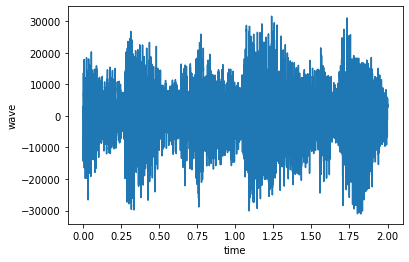

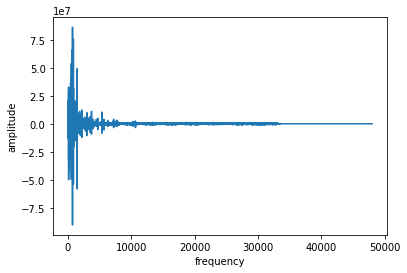

In [7]:
aud_data = song_array[segement_length_audio*23:segement_length_audio*24, 0].copy()

len_data = len(aud_data)
channel_1 = np.zeros(2**(int(np.ceil(np.log2(len_data)))))
channel_1[0:len_data] = aud_data
fourier = fft(channel_1)
t = np.linspace(0, segement_length_sec, len_data)
w = np.linspace(0, rate, len(fourier)//2)
fourier_to_plot = fourier[0:len(fourier)//2].real

plt.figure(1)
plt.plot(t, aud_data, label='aud_data')
plt.xlabel('time')
plt.ylabel('wave')
plt.figure(2)
plt.plot(w, fourier_to_plot, label='fourier_to_plot')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.show()

131072 86296465.61766818 108799240.5486259


c:\users\奎佑\appdata\local\programs\python\python36\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


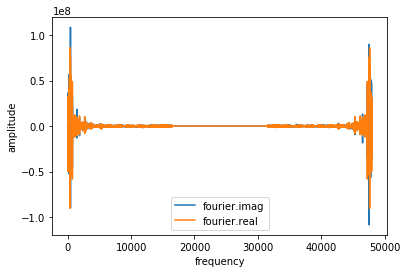

In [8]:
# plt.plot(w, fourier_to_plot, label='fourier_to_plot')
print(len(fourier), np.max(fourier.real), np.max(fourier.imag))
w1 = np.linspace(0, rate, len(fourier))
plt.plot(w1, fourier.imag, label='fourier.imag')
plt.plot(w1, fourier.real, label='fourier.real')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.legend()
plt.show()

In [ ]:
w1 = np.linspace(0, rate, len(AA[0]))
plt.plot(w1, AA[0,:,0], label='AA')

samples = sampling(mean = 0, std = 1, batch = 1, input_dim = input_dim)
predicts = generator.predict(samples)
plt.plot(w1, predicts[0,:,0], label='predicts_AA')

plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.legend()
plt.show()